In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go

import folium
from scipy.integrate import odeint
import seaborn as sns

file_path = '/kaggle/input/covid19-dataset/Covid Data.csv'
df = pd.read_csv(file_path)

df.head()
#print(df.shape)



,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [2]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns = df.columns.str.lower()

In [3]:
df = df.replace('9999-99-99', np.nan) 
df['date_died'] = df['date_died'].notna().astype(int) 
df.fillna(df.mean(), inplace=True)
print(df.columns)


Index(['usmer', 'medical_unit', 'sex', 'patient_type', 'date_died', 'intubed',
       'pneumonia', 'age', 'pregnant', 'diabetes', 'copd', 'asthma', 'inmsupr',
       'hipertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'clasiffication_final', 'icu'],
      dtype='object')


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()

for col in ['usmer', 'medical_unit', 'sex', 'patient_type', 'date_died', 'intubed',
                   'pneumonia', 'age', 'pregnant', 'diabetes', 'copd', 'asthma', 'inmsupr',
                   'hipertension', 'other_disease', 'cardiovascular', 'obesity',
                   'renal_chronic', 'tobacco', 'clasiffication_final', 'icu'] :
    df[col] = label_encoder.fit_transform(df[col])


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['date_died'])
y = df['date_died']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.95
Confusion Matrix:
[[191445   3030]
 [  7135   8105]]


# **SIR MODEL**

The SIR model is used to predict the infection dynamics of COVID-19. The model splits the population into three compartments:

* Susceptible (S): Individuals who can be infected.
* Infected (I): Currently infected individuals.
* Recovered (R): Individuals who have recovered from the disease and gained immunity.

The model's parameters include:

* β (Transmission rate): How quickly the disease spreads.
* γ (Recovery rate): How quickly individuals recover.
* R₀ (Basic reproduction number): The average number of people one infected person can spread the virus to.


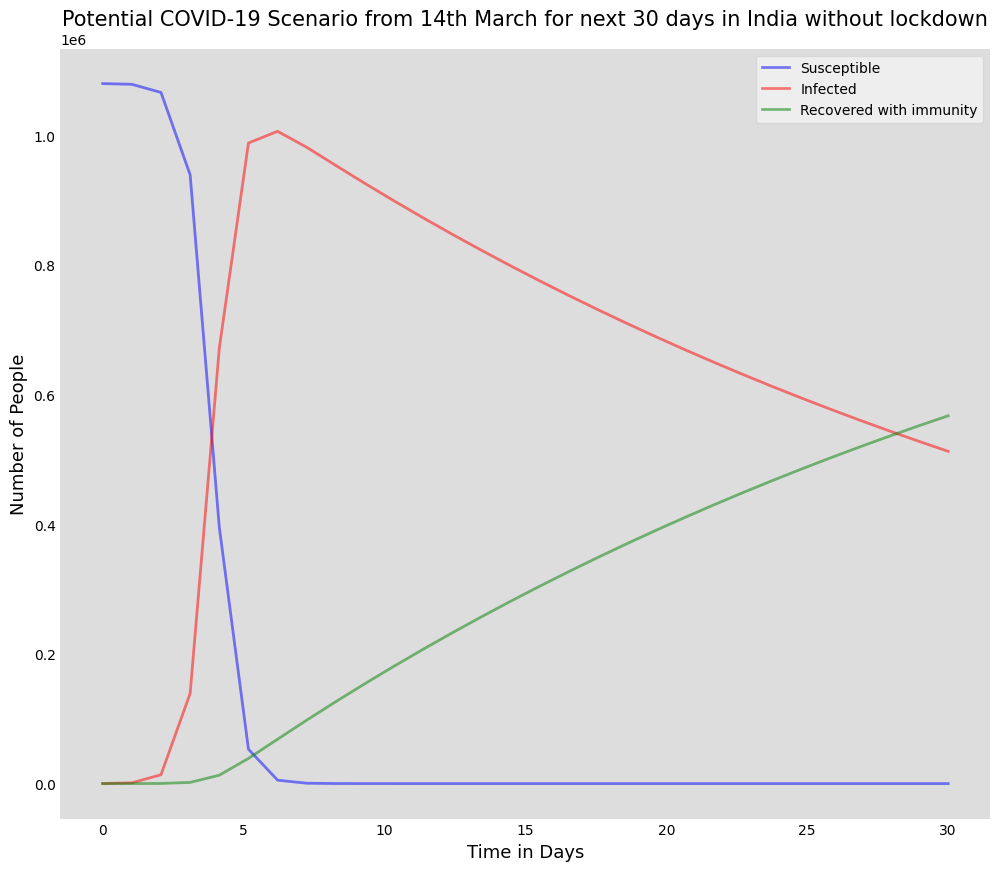

In [7]:
N = 1080000 # considering the a rough estimate of 10 lakhs as population of India who might have been exposed because 135 crore,      
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 102, 19 # till India crossed 100 cases
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 2.4, 1./35 # considering Beta & Gamma value based on China's & Europe situation
# A grid of time points (in days)
t = np.linspace(0, 30, 30)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w', figsize=(12,10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time in Days', size=13)
ax.set_ylabel('Number of People', size=13)
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
legend = ax.legend()
ax.set_facecolor('#dddddd')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
ax.set_title('Potential COVID-19 Scenario from 14th March for next 30 days in India without lockdown', size=15)
plt.show()

In [8]:
file_path = '/kaggle/input/covid19-in-india/covid_19_india.csv'
dbd_tc_pl = pd.read_csv(file_path)
dbd_tc_pl = dbd_tc_pl.head(10000)

In [9]:
dbd_tc_pl.set_index('Date', inplace=True)
data = dbd_tc_pl['Confirmed'] - (dbd_tc_pl['Cured'] + dbd_tc_pl['Deaths'])
infected = dbd_tc_pl['Confirmed']
recovered = dbd_tc_pl['Cured']

In [10]:
result = pd.DataFrame({
    'Active Cases': data,
    'Infected': infected,
    'Recovered': recovered
})

result.head()

,Active Cases,Infected,Recovered
Date,,,
2020-01-30,1,1,0
2020-01-31,1,1,0
2020-02-01,2,2,0
2020-02-02,3,3,0
2020-02-03,3,3,0


In [11]:
result.tail()

,Active Cases,Infected,Recovered
Date,,,
2020-12-29,1234,28060,26478
2020-12-29,199,13379,13042
2020-12-29,114,4190,4068
2020-12-29,243,11911,11589
2020-12-29,2482,328738,324392


**Defining Initial Values**

In [12]:
s_0 = 75000
i_0 = 603
r_0 = 43

**Parameter Optimization Using Loss Function**
The parameters of the SIR model are optimized using a loss function to minimize the error between the predicted and observed infection data. By adjusting the values of β and γ, the model was fine-tuned to closely match real-world data.

In [13]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [14]:
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-04-20', periods=180)))))

In [15]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = pres_fut
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.000001, 0.5), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Expected COVID19 Scenario in India for next 6 months (Best Case Scenario) from April 2020')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 193294.30396573665
        x: [ 2.842e-03  6.692e-04]
      nit: 23
      jac: [ 6.059e+00 -5.821e-02]
     nfev: 150
     njev: 50
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
country=India, beta=0.00284236, gamma=0.00066919, r_0:4.24744767


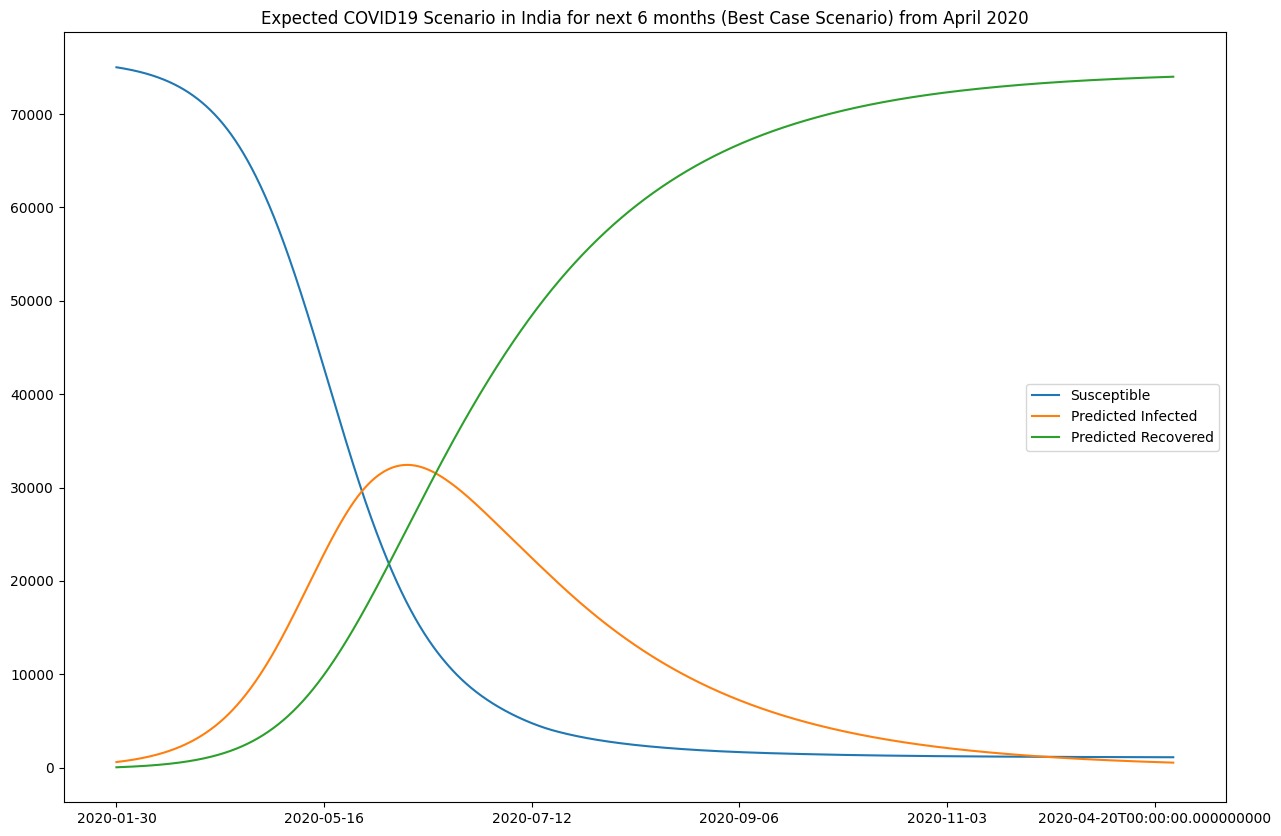

In [16]:
train(recovered, infected, data)

In [17]:
s_0 = 150000
i_0 = 603
r_0 = 43

In [18]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [19]:
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-04-20', periods=180)))))

In [20]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = pres_fut
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.000001, 0.5), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Expected COVID19 Scenario in India for next 6 months (Worst Case Scenario) from April 2020')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 182594.6202882694
        x: [ 2.197e-03  6.768e-04]
      nit: 18
      jac: [-4.381e+01 -8.036e+01]
     nfev: 162
     njev: 54
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
country=India, beta=0.00219653, gamma=0.00067684, r_0:3.24527611


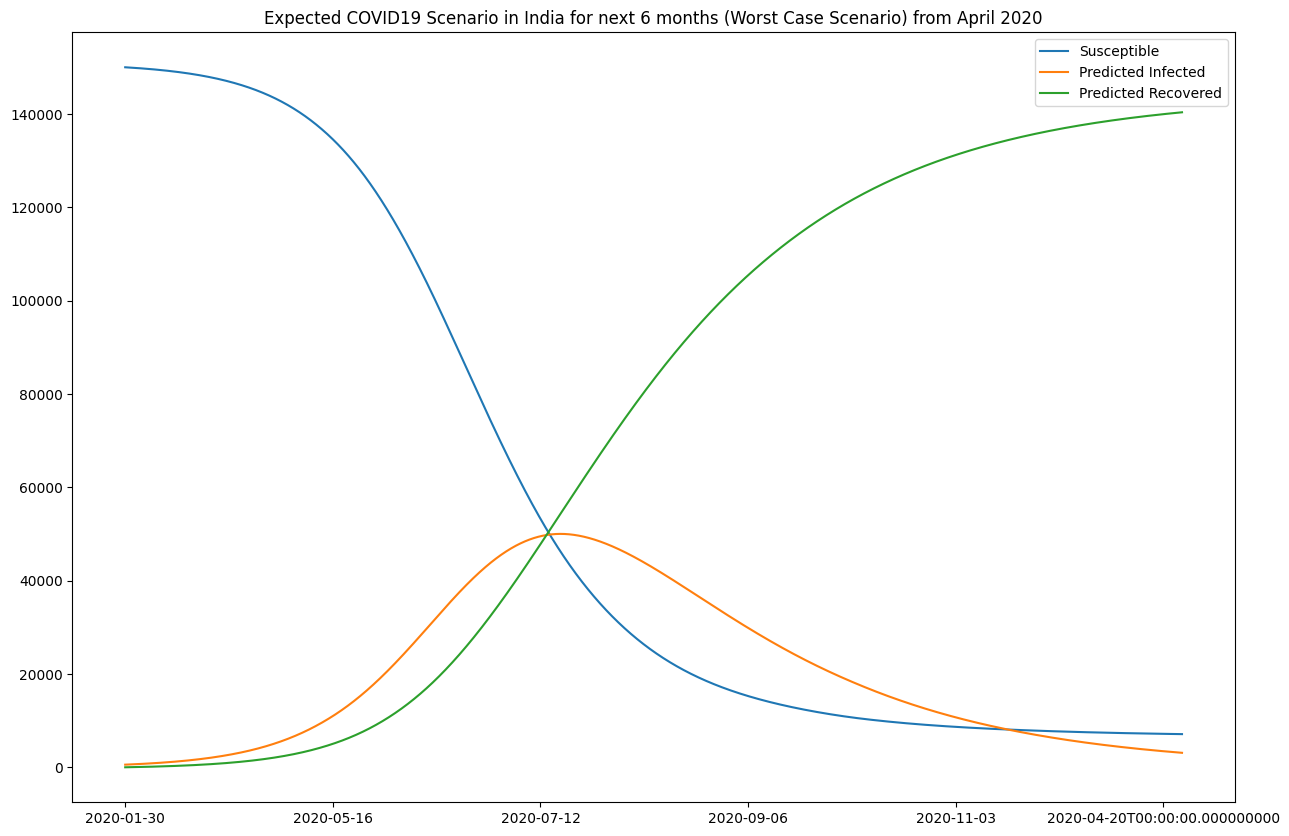

In [21]:
train(recovered, infected, data)